Training against Random Agent...
Final Assessment of Agent after training:
Wins against Random Agent: 840, Draws: 65, Losses: 95
Wins against Safe Agent: 0, Draws: 78, Losses: 922

Training against Safe Agent...
Final Assessment of Agent after training:
Wins against Random Agent: 603, Draws: 146, Losses: 251
Wins against Safe Agent: 0, Draws: 95, Losses: 905

Training with Random Opponent Selection...
Final Assessment of Agent after training:
Wins against Random Agent: 801, Draws: 72, Losses: 127
Wins against Safe Agent: 0, Draws: 70, Losses: 930



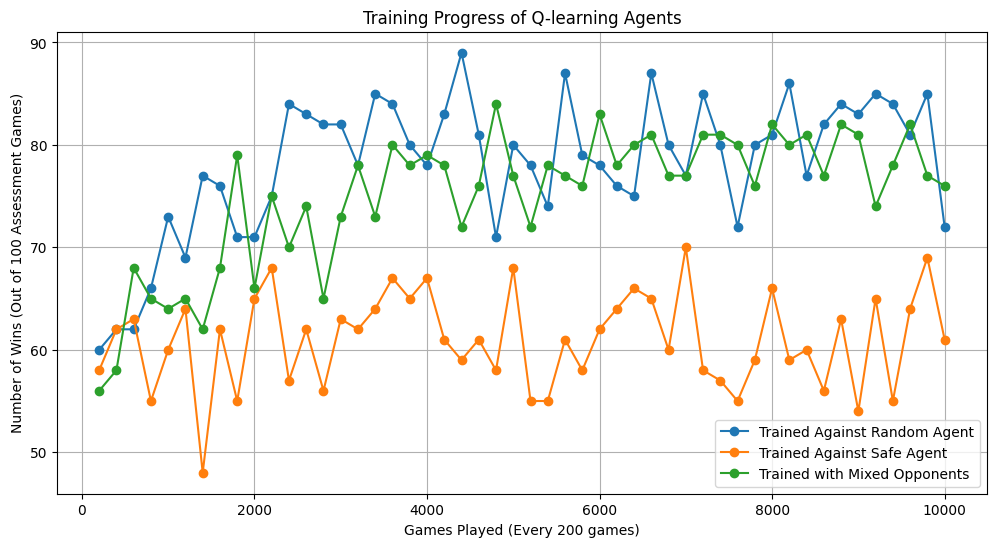

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt

class TicTacToeEnv:
    def __init__(self):
        self.board = np.full((3, 3), ' ')
        self.current_player = 'X'
    def reset(self):
        """Reset the board to an empty state."""
        self.board = np.full((3, 3), ' ')
        self.current_player = 'X'

    def act(self, row, col):
        """Place the current player's symbol on the board."""
        if self.board[row, col] == ' ':
            self.board[row, col] = self.current_player
            self.current_player = 'O' if self.current_player == 'X' else 'X'
            return True
        return False

    def check_winner(self):
        """Check if there's a winner or if the game is a draw."""
        for row in range(3):
            if self.board[row, 0] == self.board[row, 1] == self.board[row, 2] != ' ':
                return self.board[row, 0]
        for col in range(3):
            if self.board[0, col] == self.board[1, col] == self.board[2, col] != ' ':
                return self.board[0, col]
        if self.board[0, 0] == self.board[1, 1] == self.board[2, 2] != ' ':
            return self.board[0, 0]
        if self.board[0, 2] == self.board[1, 1] == self.board[2, 0] != ' ':
            return self.board[0, 2]
        if ' ' not in self.board:
            return 'Draw'
        return None

    def get_valid_moves(self):
        """Get a list of valid moves."""
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == ' ']

    def get_state(self):
        """Get the current state as a tuple."""
        return tuple(self.board.flatten())

class RandomAgent:
    def __init__(self, symbol):
        self.symbol = symbol

    def select_action(self, board):
        """Select a random action from available moves."""
        valid_moves = [(i, j) for i in range(3) for j in range(3) if board[i, j] == ' ']
        return random.choice(valid_moves)

class SafeAgent:
    def __init__(self, symbol, opponent_symbol):
        self.symbol = symbol
        self.opponent_symbol = opponent_symbol

    def select_action(self, board):
        # Check for a winning move
        for row in range(3):
            for col in range(3):
                if board[row, col] == ' ':
                    board[row, col] = self.symbol
                    if self.check_winner(board) == self.symbol:
                        return (row, col)
                    board[row, col] = ' '  # Undo move

        # Check for a blocking move
        for row in range(3):
            for col in range(3):
                if board[row, col] == ' ':
                    board[row, col] = self.opponent_symbol
                    if self.check_winner(board) == self.opponent_symbol:
                        board[row, col] = self.symbol  # Block the opponent
                        return (row, col)
                    board[row, col] = ' '  # Undo move

        # Otherwise, select a random valid move
        valid_moves = [(i, j) for i in range(3) for j in range(3) if board[i, j] == ' ']
        return random.choice(valid_moves)

    def check_winner(self, board):
        for row in range(3):
            if board[row, 0] == board[row, 1] == board[row, 2] != ' ':
                return board[row, 0]
        for col in range(3):
            if board[0, col] == board[1, col] == board[2, col] != ' ':
                return board[0, col]
        if board[0, 0] == board[1, 1] == board[2, 2] != ' ':
            return board[0, 0]
        if board[0, 2] == board[1, 1] == board[2, 0] != ' ':
            return board[0, 2]
        if ' ' not in board:
            return 'Draw'
        return None

class QLearningAgent:
    def __init__(self, symbol, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.1):
        self.symbol = symbol
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = {}

    def select_action(self, board):
        """Select an action using epsilon-greedy policy."""
        state = self.get_state(board)
        if random.uniform(0, 1) < self.epsilon:
            valid_moves = [(i, j) for i in range(3) for j in range(3) if board[i, j] == ' ']
            return random.choice(valid_moves)
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(9)
            action = np.argmax(self.q_table[state])
            return divmod(action, 3)
    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using the Q-learning update rule."""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        best_next_action = np.argmax(self.q_table[next_state])
        # Q-learning update rule
        self.q_table[state][action] += self.alpha * (reward + self.gamma * self.q_table[next_state][best_next_action] - self.q_table[state][action])

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_state(self, board):
        """Get the current state as a tuple."""
        return tuple(board.flatten())

def play_game(agent, opponent):
    """Play a game of Tic-Tac-Toe between the Q-learning agent and an opponent."""
    env = TicTacToeEnv()
    done = False
    while not done:
        if env.current_player == agent.symbol:
            row, col = agent.select_action(env.board)
            env.act(row, col)
        else:
            row, col = opponent.select_action(env.board)
            env.act(row, col)

        winner = env.check_winner()
        if winner is not None:
            done = True
            reward = 1 if winner == agent.symbol else -1 if winner == opponent.symbol else 0
            return reward

def assess_agent(agent, num_games):
    """Assess the performance of the agent against a greedy opponent."""
    opponent = RandomAgent(symbol='O')  #
    wins = 0
    for _ in range(num_games):
        outcome = play_game(agent, opponent)
        if outcome == 1:
            wins += 1
    return wins

def train_against_random_agent(num_games, assess_interval=200, assessment_games=100):
    """Train the Q-learning agent against a random agent."""
    agent = QLearningAgent(symbol='X')
    training_progress = []

    for game in range(num_games):
        env = TicTacToeEnv()
        done = False
        while not done:
            if env.current_player == agent.symbol:
                state = agent.get_state(env.board)
                row, col = agent.select_action(env.board)
                env.act(row, col)
            else:
                row, col = RandomAgent(symbol='O').select_action(env.board)
                env.act(row, col)

            winner = env.check_winner()
            if winner is not None:
                done = True
                reward = 1 if winner == agent.symbol else -1 if winner == 'O' else 0
                next_state = agent.get_state(env.board)
                agent.update_q_value(state, row * 3 + col, reward, next_state)
                agent.decay_epsilon()

        if (game + 1) % assess_interval == 0:
            wins = assess_agent(agent, assessment_games)
            training_progress.append(wins)

    return agent, training_progress

def train_against_safe_agent(num_games, assess_interval=200, assessment_games=100):
    """Train the Q-learning agent against a safe agent."""
    agent = QLearningAgent(symbol='X')
    training_progress = []

    for game in range(num_games):
        env = TicTacToeEnv()
        done = False
        while not done:
            if env.current_player == agent.symbol:
                state = agent.get_state(env.board)
                row, col = agent.select_action(env.board)
                env.act(row, col)
            else:
                row, col = SafeAgent(symbol='O', opponent_symbol='X').select_action(env.board)
                env.act(row, col)

            winner = env.check_winner()
            if winner is not None:
                done = True
                reward = 1 if winner == agent.symbol else -1 if winner == 'O' else 0
                next_state = agent.get_state(env.board)
                agent.update_q_value(state, row * 3 + col, reward, next_state)
                agent.decay_epsilon()

        if (game + 1) % assess_interval == 0:
            wins = assess_agent(agent, assessment_games)
            training_progress.append(wins)

    return agent, training_progress

def train_with_random_opponent(num_games, assess_interval=200, assessment_games=100):
    """Train the Q-learning agent against random and safe agents."""
    agent = QLearningAgent(symbol='X')
    training_progress = []

    for game in range(num_games):
        env = TicTacToeEnv()
        done = False
        while not done:
            if env.current_player == agent.symbol:
                state = agent.get_state(env.board)
                row, col = agent.select_action(env.board)
                env.act(row, col)
            else:
                opponent = RandomAgent(symbol='O') if random.choice([True, False]) else SafeAgent(symbol='O', opponent_symbol='X')
                row, col = opponent.select_action(env.board)
                env.act(row, col)

            winner = env.check_winner()
            if winner is not None:
                done = True
                reward = 1 if winner == agent.symbol else -1 if winner == 'O' else 0
                next_state = agent.get_state(env.board)
                agent.update_q_value(state, row * 3 + col, reward, next_state)
                agent.decay_epsilon()


        if (game + 1) % assess_interval == 0:
            wins = assess_agent(agent, assessment_games)
            training_progress.append(wins)

    return agent, training_progress

def final_assessment(agent, num_games=1000):
    """Assess the trained agent's performance over a specified number of games."""

    wins_random = 0
    draws_random = 0
    losses_random = 0


    wins_safe = 0
    draws_safe = 0
    losses_safe = 0

    random_opponent = RandomAgent(symbol='O')
    safe_opponent = SafeAgent(symbol='O', opponent_symbol='X')

    # Play 1000 games against Random Agent
    for _ in range(num_games):
        outcome = play_game(agent, random_opponent)
        if outcome == 1:
            wins_random += 1
        elif outcome == 0:
            draws_random += 1
        else:
            losses_random += 1

    # Play 1000 games against Safe Agent
    for _ in range(num_games):
        outcome = play_game(agent, safe_opponent)
        if outcome == 1:
            wins_safe += 1
        elif outcome == 0:
            draws_safe += 1
        else:
            losses_safe += 1
    print(f"Final Assessment of Agent after training:")
    print(f"Wins against Random Agent: {wins_random}, Draws: {draws_random}, Losses: {losses_random}")
    print(f"Wins against Safe Agent: {wins_safe}, Draws: {draws_safe}, Losses: {losses_safe}\n")

    return wins_random, draws_random, losses_random, wins_safe, draws_safe, losses_safe

num_training_games = 10000

# 1. Train against Random Agent
print("Training against Random Agent...")
agent_random, training_progress_random = train_against_random_agent(num_training_games)
final_assessment(agent_random)

# 2. Train against Safe Agent
print("Training against Safe Agent...")
agent_safe, training_progress_safe = train_against_safe_agent(num_training_games)
final_assessment(agent_safe)

# 3. Train with Random Opponent Selection
print("Training with Random Opponent Selection...")
agent_mixed, training_progress_mixed = train_with_random_opponent(num_training_games)
final_assessment(agent_mixed)

# Plotting the training progress for each agent
plt.figure(figsize=(12, 6))
plt.plot(range(200, num_training_games + 1, 200), training_progress_random, label='Trained Against Random Agent', marker='o')
plt.plot(range(200, num_training_games + 1, 200), training_progress_safe, label='Trained Against Safe Agent', marker='o')
plt.plot(range(200, num_training_games + 1, 200), training_progress_mixed, label='Trained with Mixed Opponents', marker='o')
plt.xlabel('Games Played (Every 200 games)')
plt.ylabel('Number of Wins (Out of 100 Assessment Games)')
plt.title('Training Progress of Q-learning Agents')
plt.legend()
plt.grid()
plt.show()


4. The agent trained against the Random Agent is the best based on its overall performance against the Random Agent, achieving the highest number of wins and the fewest losses. While it did not win against the Safe Agent, it shows that it is capable of effectively countering random strategies, which is a critical aspect of agent performance in many environments.

5. A Q-learning agent is not inherently unbeatable, as its performance depends on various factors like the environment's complexity and opponent strategies. To improve training, consider enhancing exploration strategies (e.g., epsilon-greedy or Boltzmann exploration), using function approximation like neural networks, and implementing experience replay for better learning stability. Self-play and curriculum learning can help the agent develop robust strategies over time. Additionally, incorporating opponent modeling and exploring advanced algorithms like Double Q-Learning can further enhance the agent's adaptability and performance against diverse opponents.